# Домашнее задание №3: Классификация временных рядов с помощью нейросетей. (1 балл (+ возможные бонусы))

<span style="color: red; font-size: 14pt">Дедлайн: 6 сентября 23:59</span>

**Оформление дз**: 

- Task short name: ``HW3 NN``.
- Выполненное дз сохраните в файл ``ML2018_<фамилия>_HW#.ipynb``, к примеру -- ``ML2018_ivanov_HW3.ipynb``
- Присылайте выполненное задание на почту <a href="mailto:ml4megafon_2018_08@bigdatateam.org"> ml4megafon_2018_08@bigdatateam.org</a> с темой письма `` HW# Short name. ФИО ``. 

    Например: `` HW3 NN. Иванов Иван Иванович. ``

**Вопросы**:
- По данному заданию присылайте свои вопросы в Telegram Радославу (@nexes).

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

   http://bit.ly/ml4megafon_august18_hw3nn_feedback

__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети. Если у Вас нет опыта работы с нейронными сетями и соотвествующими фреймворками, пожалуйста, выберите другое задание.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Мы будем решать достаточно классическую задачу классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [10]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

In [11]:
y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

In [12]:
legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

In [13]:
from sklearn.decomposition import PCA
pca = PCA()

In [14]:
X_train_pca = pca.fit_transform(X_train_with_engineered_features)

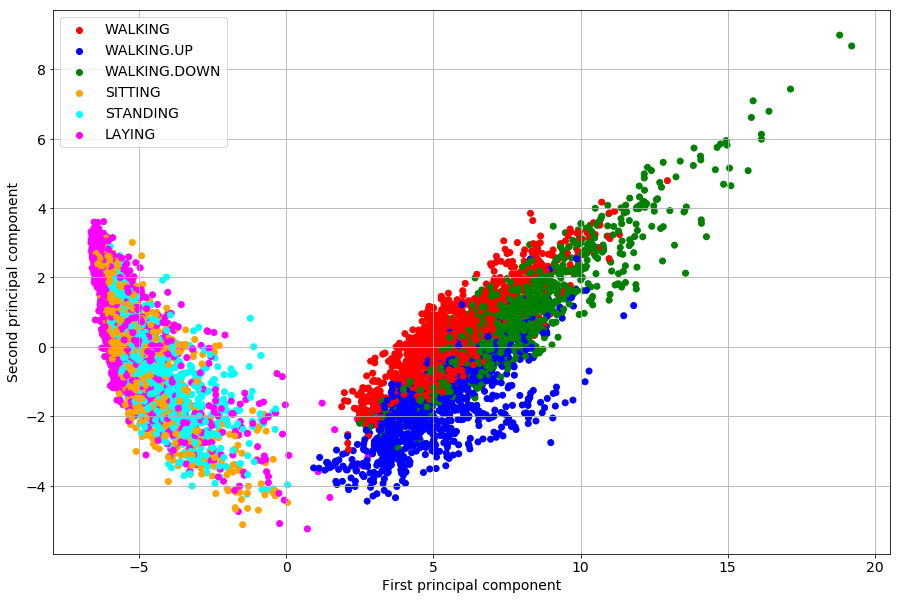

In [15]:
plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

### Часть 0. Разогрев. 
Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

### Часть 1. Предобработка данных.
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition).

In [16]:
import os

In [17]:
os.path.join('data', 'etc', 'file1.asdas')

'data/etc/file1.asdas'

In [31]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [32]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


### Часть 2. Построение сети и эксперименты. (100% +)
Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 80%. Это может оказаться нетривиальной задачей, поэтому трезво оценивайте свои силы. 

__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - лучше выберите другое: по Facebook Prophet или по ARIMA.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи задача была решена благодаря ..."

Базовая модель построена с использованием библиотеки `keras` для вас. Вы можете использовать любой знакомый вам фреймворк. Удачи в экспериментах. 

__Bonus__: при достижении 85% accuracy - 15% бонусных баллов, при достижении 89% accuracy - 40% бонусных баллов (т.е. 15% + 25%).

In [33]:
import keras

Using TensorFlow backend.


In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, SimpleRNN, Embedding, Reshape
from keras.utils import to_categorical
from keras import regularizers

In [35]:
#Create model
model = Sequential()
model.add(LSTM(units=16, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

Метки классов стоит перевести в one-hot-encoded формат (теперь это векторы вероятностей принадлежности классу). 

In [184]:
def one_hot_encode(y, n_classes):
    # y - [n_samples, 1] - class labels
    # n_classes - int - number of unique class labels
    #
    # return:
    # one_hot_encoded_y - [n_samples, n_classes] of type float - probabilities of 
    #                                                            class-accordance (target class has 1., other - 0.)

    ### Your code here

In [37]:
y_train_one_hot = one_hot_encode(y_train, 6)
y_test_one_hot = one_hot_encode(y_test, 6)

In [38]:
model.fit(X_train, y_train_one_hot, batch_size=128, epochs=20)

Epoch 1/20
7352/7352 [==============================] - 7s 972us/step - loss: 1.7121 - acc: 0.3323
Epoch 2/20
7352/7352 [==============================] - 6s 824us/step - loss: 2.3554 - acc: 0.4597
Epoch 3/20
7352/7352 [==============================] - 6s 797us/step - loss: 7.9978 - acc: 0.3202
Epoch 4/20
7352/7352 [==============================] - 6s 810us/step - loss: 13.7906 - acc: 0.1353
Epoch 5/20
7352/7352 [==============================] - 6s 797us/step - loss: 13.6924 - acc: 0.1434
Epoch 6/20
7352/7352 [==============================] - 6s 808us/step - loss: 13.6353 - acc: 0.1485
Epoch 7/20
7352/7352 [==============================] - 6s 758us/step - loss: 12.8950 - acc: 0.1953
Epoch 8/20
7352/7352 [==============================] - 6s 783us/step - loss: 12.0917 - acc: 0.2452
Epoch 9/20
7352/7352 [==============================] - 5s 747us/step - loss: 12.1266 - acc: 0.2431
Epoch 10/20
7352/7352 [==============================] - 6s 770us/step - loss: 12.1330 - acc: 0.2427
Ep

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
accuracy_score(y_test, model.predict_classes(X_test))

0.22768917543264336

In [41]:
### Your code and experiments here

_Ваш отчет здесь_

Пожалуйста, оставьте отзыв о домашнем задании: [link](http://bit.ly/ml4megafon_august18_hw3nn_feedback)